## Analisi di Spiegabilità (XAI) per Modelli GNN su Dati di Brain-Imaging

### *Notebook di Analisi Esplicativa*

In questo notebook, esploreremo le predizioni di un modello Graph Neural Network (GNN) pre-addestrato per la segmentazione di tumori cerebrali. L'obiettivo non è solo valutare l'accuratezza, ma capire **perché** il modello prende determinate decisioni. Utilizzeremo diverse tecniche di Explainable AI (XAI) per identificare le feature, i nodi vicini e le connessioni più influenti.

---

## 1. Setup dell'Ambiente e Importazioni

Iniziamo importando le librerie necessarie e configurando l'ambiente di lavoro.

- **Librerie Core:** `os`, `sys`, `numpy` per la gestione del sistema e operazioni numeriche.
- **PyTorch & PyG:** `torch` è il framework di base; `torch_geometric` è la libreria essenziale per i GNN.
- **MONAI:** Utilizziamo `set_determinism` per garantire la riproducibilità degli esperimenti, un aspetto cruciale nell'analisi XAI.
- **Explainability:** Importiamo `Explainer` e `GNNExplainer` da PyG, che sono gli strumenti principali per questa analisi.
- **Visualizzazione:** `matplotlib` per la creazione di grafici.

In [1]:
# --- Librerie di base e di sistema ---
import os
import sys
import random
from sys import platform

# --- Gestione dei percorsi ---
sys.path.append('..')

# --- Framework e librerie GNN ---
import torch
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import GNNExplainer
import numpy as np

# --- Librerie ausiliarie e di visualizzazione ---
from monai.utils import set_determinism
from src.helpers.config import get_config
from src.models.gnn import GraphSAGE, GAT, ChebNet
import matplotlib.pyplot as plt
import time

## 2. Configurazione e Riproducibilità

### 2.1 Definizione dei Percorsi
Carichiamo le configurazioni e definiamo i percorsi principali per i dati, i modelli e i report.

In [2]:
# Definisce il percorso base (la cartella principale del progetto)
_base_path = os.path.abspath('..')

# Definizione dei percorsi
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
graph_path = os.path.join(data_path, _config.get('GRAPH_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))

if platform == 'win32':
    data_path = data_path.replace('/', '\\')
    graph_path = graph_path.replace('/', '\\')
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')

### 2.2 Seed per la Riproducibilità
L'analisi di spiegabilità può avere componenti stocastiche. Fissare un seed è fondamentale per garantire che i risultati siano consistenti e confrontabili tra diverse esecuzioni.

In [3]:
# Impostare un seed per la riproducibilità
set_determinism(seed=3)
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

## 3. Definizione del Modello e dei Dati

### 3.1 Classi di Output
Definiamo i nomi delle classi target. Questo mapping da indici numerici a etichette testuali sarà essenziale per interpretare i risultati in modo intuitivo.

In [4]:
# --- Definizione delle Classi di Output ---
# Si mappa l'indice numerico di ogni classe a un'etichetta testuale
# per rendere più interpretabili i risultati e i grafici.

classes = [
    "Sano/Background",      # Classe 0
    "NCR/NET",              # Classe 1 (Nucleo Necrotico/Non-Enhancing)
    "Edema (ED)",           # Classe 2
    "Tumore Enhancing (ET)" # Classe 3
]

### 3.2 Architettura del Modello GNN
Qui definiamo l'architettura del nostro modello. Per questa analisi, utilizzeremo **ChebNet**, una Graph Convolutional Network basata su approssimazioni spettrali con polinomi di Chebyshev.

**Scelta di ChebNet:**
- **Localizzazione Spettrale:** Permette di definire filtri che operano in un intorno localizzato del grafo.
- **Efficienza:** Computazionalmente vantaggioso rispetto ad altri metodi spettrali.
- **Parametro K:** L'ordine del polinomio `K` definisce la dimensione del vicinato considerato da ogni "neurone" (K-hop neighborhood), un parametro chiave per l'interpretabilità.

In [5]:
# --- Definizione degli Iperparametri del Modello ---
# Questi parametri definiscono l'architettura della GNN. Vengono elencati
# per completezza, ma solo quelli di ChebNet sono attivamente usati in questo notebook.

# Parametri condivisi
num_node_features = 50          # Dimensione delle feature di input per ogni nodo
num_classes = 4                 # Numero di classi di output
dropout = .0                    # Dropout disattivato per la fase di analisi
hidden_channels = [512, 512, 512, 512, 512, 512, 512]  # Unità nascoste per ogni layer

# Parametri specifici per ChebNet
k = 4                           # Ordine del polinomio (dimensione del vicinato di convoluzione)

# --- Istanziazione del Modello ---
# Si crea l'istanza del modello ChebNet che verrà successivamente
# caricata con i pesi pre-addestrati.
model = ChebNet(
    in_channels=num_node_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=dropout,
    K=k
)
print(f"Modello creato: {model.__class__.__name__}")

Modello creato: ChebNet


## 4. Caricamento Dati e Selezione del Target di Analisi

### 4.1 Funzione di Caricamento
Questa funzione helper si occupa di caricare un singolo grafo (paziente) dal disco.

- Funzione per la ricerca e il caricamento di un grafo

In [6]:
# --- Funzione Helper per il Caricamento dei Dati ---
# Questa funzione carica un singolo grafo (paziente) dal disco,
# gestendo la costruzione del percorso e il controllo degli errori.

def find_and_load_graph(subject_id):
    """
    Carica un grafo specifico per l'analisi dato il suo ID.
    
    Args:
        subject_id (str): ID del soggetto (es. "BraTS-GLI-00017-001").
        
    Returns:
        (torch_geometric.data.Data, str): Tupla contenente i dati del grafo e l'ID del soggetto.
    """
    # Costruisce il percorso completo del file
    graph_file = os.path.join(graph_path, subject_id, f"{subject_id}.graph")
    
    # Controlla l'esistenza del file per prevenire errori
    if not os.path.isfile(graph_file):
        raise FileNotFoundError(f"File grafo non trovato per il soggetto {subject_id}")
    
    print(f"Caricamento grafo: {graph_file}")
    
    # Carica l'oggetto Data di PyTorch Geometric
    data = torch.load(graph_file, weights_only=False)
    
    return data, subject_id

In [7]:
# --- Caricamento del Grafo Selezionato ---
# Questa cella esegue il caricamento del grafo utilizzando l'ID del soggetto
# definito nella cella di configurazione. Se non ancora definito, usa un valore di default.

# Imposta un ID di default per testare la cella singolarmente
if 'SUBJECT_ID_TO_LOAD' not in locals():
    SUBJECT_ID_TO_LOAD = "BraTS-GLI-00577-000"
    print(f"ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Si utilizza il valore di default: {SUBJECT_ID_TO_LOAD}")

# Carica il grafo e stampa un riepilogo delle sue proprietà
try:
    print(f"--- Inizio caricamento per il soggetto: {SUBJECT_ID_TO_LOAD} ---")
    data, subject_id = find_and_load_graph(SUBJECT_ID_TO_LOAD)
    print(f"Grafo caricato con successo: {subject_id}")
    print(f"  - Numero di nodi: {data.num_nodes}")
    print(f"  - Numero di archi: {data.num_edges}")
    print(f"  - Numero di feature per nodo: {data.num_node_features}")
except (FileNotFoundError, IOError) as e:
    print(f"ERRORE: {e}")
    # Interrompe l'esecuzione se il file non viene trovato
    raise e

ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Si utilizza il valore di default: BraTS-GLI-00577-000
--- Inizio caricamento per il soggetto: BraTS-GLI-00577-000 ---
Caricamento grafo: C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\data\graphs\BraTS-GLI-00577-000\BraTS-GLI-00577-000.graph
Grafo caricato con successo: BraTS-GLI-00577-000
  - Numero di nodi: 2901
  - Numero di archi: 29010
  - Numero di feature per nodo: 50


### 4.2 Pannello di Controllo dell'Analisi
Questa è la cella più importante per guidare l'esperimento. Qui definiamo:
1.  **Quale paziente (`subject_id`) analizzare.**
2.  **Come selezionare il nodo (`NODE_SELECTION_METHOD`)** da spiegare all'interno del grafo del paziente.

Questo approccio permette di rieseguire l'analisi su target diversi in modo rapido e controllato.

In [8]:
# ======================================================================
#                   PANNELLO DI CONTROLLO SPERIMENTALE
# ======================================================================
# Questa cella centralizza i parametri per l'analisi di spiegabilità,
# permettendo di modificare l'oggetto dello studio senza alterare il codice sottostante.

# --- 1. Selezione del Soggetto di Studio (Grafo) ---
# Specifica l'identificativo del soggetto (grafo) da caricare per l'analisi.
# La selezione può essere guidata dai risultati ottenuti in fase di test,
# focalizzandosi su casi di particolare interesse (es. predizioni incerte o errate).
SUBJECT_ID_TO_LOAD = "BraTS-GLI-00017-001"


# --- 2. Criterio di Selezione del Nodo Target per la Spiegabilità ---
# Definisce la strategia per l'identificazione automatica del nodo (superpixel)
# la cui predizione verrà spiegata.
#
# Strategie disponibili:
# 'highest_confidence': Nodo con la massima probabilità per la classe corretta.
#                       (Utile per validare ciò che il modello considera un "esempio perfetto").
# 'lowest_confidence':  Nodo corretto con la minima probabilità > 0.5.
#                       (Utile per analizzare casi di incertezza).
# 'first_incorrect':    Primo nodo classificato erroneamente.
#                       (Cruciale per il debug e la comprensione degli errori).
# 'random_correct':     Selezione stocastica di un nodo corretto.
# 'random_incorrect':   Selezione stocastica di un nodo errato.
# 'specific_class':     Analisi mirata su una specifica classe di tessuto.
# 'specific_index':     Selezione manuale di un nodo di interesse pre-identificato.
NODE_SELECTION_METHOD = 'lowest_confidence'

# --- Parametri Dipendenti dal Metodo di Selezione ---

# Per 'specific_class': definire l'indice della classe di tessuto target.
# Mapping: 0:Sano, 1:NCR/NET, 2:Edema, 3:Tumore Enhancing (ET)
TARGET_CLASS_FOR_SELECTION = 3

# Per 'specific_index': definire l'indice del nodo da analizzare.
TARGET_INDEX_FOR_SELECTION = 847

# --- Riepilogo della Configurazione ---
print("--- Configurazione dell'analisi impostata ---")
print(f"Grafo da caricare: {SUBJECT_ID_TO_LOAD}")
print(f"Criterio di selezione del nodo: {NODE_SELECTION_METHOD}")
if NODE_SELECTION_METHOD == 'specific_class':
    print(f"Classe target per la selezione: {TARGET_CLASS_FOR_SELECTION} ({classes[TARGET_CLASS_FOR_SELECTION]})")
if NODE_SELECTION_METHOD == 'specific_index':
    print(f"Indice specifico del nodo target: {TARGET_INDEX_FOR_SELECTION}")

--- Configurazione dell'analisi impostata ---
Grafo da caricare: BraTS-GLI-00017-001
Criterio di selezione del nodo: lowest_confidence


### 4.3 Caricamento del Modello Pre-addestrato e Valutazione
Ora carichiamo i pesi del miglior modello ChebNet salvato durante l'addestramento e verifichiamo la sua performance sul grafo selezionato. Questo ci dà un contesto sull'affidabilità delle predizioni che andremo a spiegare.

In [9]:
# --- Caricamento dei Pesi del Modello Pre-addestrato ---
# Si identificano i file del modello ChebNet salvati durante l'addestramento.
# Viene selezionato e caricato l'ultimo modello "best" disponibile.

# Cerca i file del modello nella cartella dei modelli salvati
model_files = [f for f in os.listdir(saved_path) if 'CHEBNET' in f and f.endswith('_best.pth')]

if not model_files:
    raise FileNotFoundError("Nessun modello ChebNet pre-addestrato trovato nella directory 'saved/'.")

# Seleziona il modello più recente (assumendo un ordinamento temporale)
latest_model = sorted(model_files)[-1]
print(f"Utilizzo del modello pre-addestrato: {latest_model}")

# Carica i pesi nel modello istanziato e lo imposta in modalità valutazione
model.load_state_dict(torch.load(os.path.join(saved_path, latest_model), map_location=torch.device('cpu')))
model.eval()

Utilizzo del modello pre-addestrato: CHEBNET_1739029370_best.pth


ChebNet(
  (layers): ModuleList(
    (0): ChebConv(50, 512, K=4, normalization=sym)
    (1-6): 6 x ChebConv(512, 512, K=4, normalization=sym)
    (7): ChebConv(512, 4, K=4, normalization=sym)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## **Valutazione dell'Accuratezza**

- Verifica dell'accuratezza del modello sul grafo caricato.

In [10]:
# --- Valutazione del Modello sul Grafo Selezionato ---
# Si eseguono le predizioni sul grafo caricato per ottenere un contesto
# sulla performance del modello in questo specifico caso.

with torch.no_grad(): # Disattiva il calcolo dei gradienti per l'inferenza
    # Esegue il forward pass del modello
    outputs = model(data.x, data.edge_index.type(torch.int64))
    
    # Ottiene le etichette predette prendendo la classe con il punteggio più alto
    predicted_labels = outputs.argmax(dim=1)

    # Calcola e stampa l'accuratezza complessiva sul grafo
    # Confronta le etichette predette con quelle reali (ground truth)
    try:
        correct_predictions = (predicted_labels == data.y.long())
        accuracy = correct_predictions.float().mean().item()
        print(f"Accuratezza del modello sul grafo {subject_id}: {accuracy:.4f}")
    except Exception as e:
        print(f"Avviso: impossibile calcolare l'accuratezza. Etichette reali 'data.y' potrebbero mancare o avere un formato non valido. Errore: {e}")

    # Calcola e stampa la distribuzione delle classi predette
    class_counts = torch.bincount(predicted_labels, minlength=num_classes)
    print(f"Distribuzione delle classi predette: {class_counts.numpy()}")

Accuratezza del modello sul grafo BraTS-GLI-00577-000: 0.9924
Distribuzione delle classi predette: [2687   34  112   68]


In [11]:
# --- Selezione Automatica del Nodo Target ---

import torch.nn.functional as F

print("\n--- Selezione del nodo target in base alla configurazione ---")

# Calcola le probabilità di predizione per tutti i nodi
with torch.no_grad():
    all_logits = model(data.x, data.edge_index.type(torch.int64))
    all_probs = F.softmax(all_logits, dim=1)
    max_probs, _ = torch.max(all_probs, dim=1)

# Crea maschere booleane per nodi predetti correttamente o erroneamente
correct_preds_mask = (predicted_labels == data.y.long())
incorrect_preds_mask = ~correct_preds_mask

# Applica la strategia di selezione definita dalla variabile NODE_SELECTION_METHOD
selected_node_index = -1
if NODE_SELECTION_METHOD == 'highest_confidence':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmax()].item()

elif NODE_SELECTION_METHOD == 'lowest_confidence':
    # Considera solo nodi corretti con probabilità > 0.5
    low_conf_mask = (max_probs > 0.5)
    candidates = (correct_preds_mask & low_conf_mask).nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmin()].item()

elif NODE_SELECTION_METHOD == 'first_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[0].item()

elif NODE_SELECTION_METHOD == 'random_correct':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'random_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_class':
    class_mask = (predicted_labels == TARGET_CLASS_FOR_SELECTION)
    candidates = class_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_index':
    selected_node_index = TARGET_INDEX_FOR_SELECTION

# Gestisce il caso in cui nessun nodo soddisfi i criteri, selezionandone uno casuale
if selected_node_index == -1:
    print(f"ATTENZIONE: Nessun nodo trovato con il metodo '{NODE_SELECTION_METHOD}'. Si seleziona un nodo casuale.")
    selected_node_index = random.randint(0, data.num_nodes - 1)

# Assegna l'indice del nodo selezionato a una variabile per l'uso nelle celle successive
node_to_explain_index = selected_node_index

# Stampa un riepilogo del nodo selezionato per l'analisi
pred_class_idx = predicted_labels[node_to_explain_index].item()
real_class_idx = data.y[node_to_explain_index].long().item()
print(f"\n---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice {node_to_explain_index} <---")
print(f"  - Classe Predetta: {classes[pred_class_idx]} (Prob: {max_probs[node_to_explain_index]:.4f})")
print(f"  - Classe Reale:    {classes[real_class_idx]}")
print(f"  - Predizione:      {'Corretta' if pred_class_idx == real_class_idx else 'ERRATA'}")


--- Selezione del nodo target in base alla configurazione ---

---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice 1048 <---
  - Classe Predetta: Edema (ED) (Prob: 0.6604)
  - Classe Reale:    Edema (ED)
  - Predizione:      Corretta


## 5. Tecniche di Spiegabilità (XAI)

Applicheremo tre diverse tecniche XAI per ottenere una visione completa e robusta di ciò che il modello ha imparato.

### 5.1 Metodo Basato sul Modello: GNNExplainer
**GNNExplainer** è un metodo *model-specific* che apprende una maschera "soft" sul grafo di calcolo del nodo target. Cerca di trovare il sottografo e il sottoinsieme di feature più piccoli ma più influenti per la predizione.

- **Cosa Spiega:** L'importanza di **feature** e **archi (vicini)**.
- **Come Funziona:** Ottimizza una maschera per massimizzare l'informazione mutua tra la predizione del modello e la distribuzione del sottografo.
- **Punti di Forza:** Fornisce una spiegazione strutturata (sottografo) e basata sulle feature.

In [12]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 1: GNNEXPLAINER
# ======================================================================
# Si utilizza GNNExplainer per identificare il sottografo e le feature
# più influenti per la predizione del nodo target selezionato.

import torch.nn.functional as F

# --- 1. Configurazione dell'Algoritmo GNNExplainer ---
# Si impostano i parametri per l'apprendimento della maschera.
# I coefficienti (coeffs) servono a regolarizzare la spiegazione,
# promuovendo maschere "sparse" (poche feature e pochi archi importanti).
gnn_explainer_algorithm = GNNExplainer(
    epochs=200,
    lr=0.01,
    coeffs={
        "edge_size": 0.005,      # Penalità sulla dimensione del sottografo
        "node_feat_size": 1.0,   # Penalità sull'uso delle feature
        "edge_ent": 1.0,         # Regolarizzazione sull'entropia degli archi
        "node_feat_ent": 0.1,    # Regolarizzazione sull'entropia delle feature
    }
)

# --- 2. Configurazione dell'Oggetto Explainer ---
# Si definisce il task (classificazione di nodi) e il tipo di output
# che GNNExplainer deve aspettarsi dal modello.
model_config = ModelConfig(
    mode="multiclass_classification",
    task_level="node",
    # Se il modello restituisce logits, cambiare in "raw".
    # Se restituisce probabilità logaritmiche (come dopo LogSoftmax), usare "log_probs".
    return_type="raw"
)

# Si crea l'oggetto Explainer principale
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer_algorithm,
    explanation_type="phenomenon",
    model_config=model_config,
    node_mask_type="attributes",   # Chiede di spiegare l'importanza delle feature
    edge_mask_type="object",       # Chiede di spiegare l'importanza degli archi
)

# --- 3. Generazione della Spiegazione ---
# Si esegue l'algoritmo sul nodo target precedentemente identificato.
print(f"\n--- Esecuzione di GNNExplainer per il nodo: {node_to_explain_index} ---")
start_time = time.time()

# Si genera la spiegazione per il nodo specifico (index)
# rispetto all'insieme di tutte le predizioni (target).
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64),
    index=node_to_explain_index,
    target=predicted_labels.type(torch.LongTensor)
)

elapsed_time = time.time() - start_time
print(f"Spiegazione generata in {elapsed_time:.2f} secondi.")

# --- 4. Riepilogo dei Risultati della Spiegazione ---
# Si stampano le informazioni principali restituite da GNNExplainer.
print("\n--- Informazioni sulla Spiegazione Generata ---")
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:
    print(f"Ottenuta maschera di importanza per le feature (node_mask) di forma: {explanation.node_mask.shape}")
else:
    print("Maschera per le feature (node_mask) non generata.")

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    print(f"Ottenuta maschera di importanza per gli archi (edge_mask) di forma: {explanation.edge_mask.shape}")
else:
    print("Maschera per gli archi (edge_mask) non generata.")


--- Esecuzione di GNNExplainer per il nodo: 1048 ---
Spiegazione generata in 455.70 secondi.

--- Informazioni sulla Spiegazione Generata ---
Ottenuta maschera di importanza per le feature (node_mask) di forma: torch.Size([2901, 50])
Ottenuta maschera di importanza per gli archi (edge_mask) di forma: torch.Size([29010])


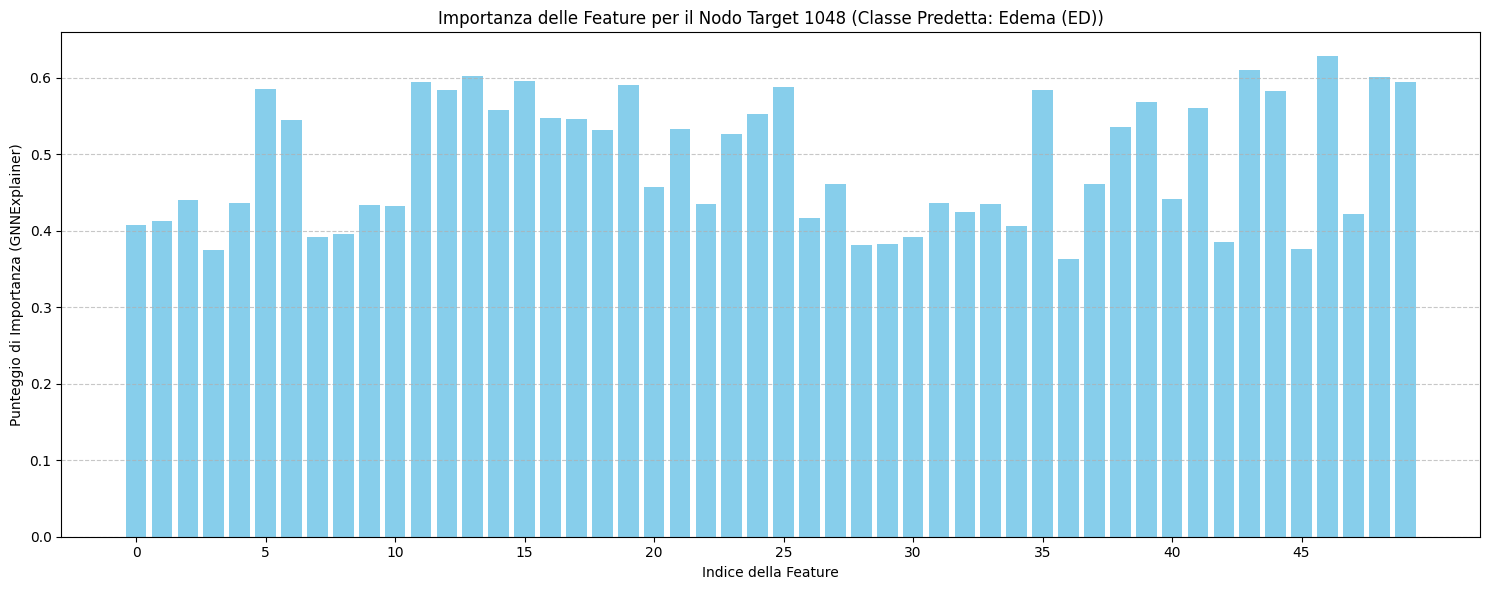


Top 10 feature più importanti per il nodo 1048:
  - Feature 46: Importanza = 0.6283
  - Feature 43: Importanza = 0.6108
  - Feature 13: Importanza = 0.6031
  - Feature 48: Importanza = 0.6017
  - Feature 15: Importanza = 0.5964
  - Feature 11: Importanza = 0.5947
  - Feature 49: Importanza = 0.5946
  - Feature 19: Importanza = 0.5912
  - Feature 25: Importanza = 0.5879
  - Feature 5: Importanza = 0.5855


In [13]:
# --- Visualizzazione dell'Importanza delle Feature (GNNExplainer) ---
# Si analizza e visualizza la maschera di importanza delle feature (node_mask)
# restituita da GNNExplainer per il nodo target.

# Controlla che la maschera delle feature esista e abbia il formato corretto
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:

    # Estrae i punteggi di importanza per le feature del solo nodo target
    target_feature_importances = explanation.node_mask[node_to_explain_index].cpu().detach().numpy()
    
    # --- Grafico a Barre: Importanza di tutte le feature ---
    plt.figure(figsize=(15, 6))
    bar_positions = np.arange(num_node_features)
    plt.bar(bar_positions, target_feature_importances, color='skyblue')
    
    plt.xlabel("Indice della Feature")
    plt.ylabel("Punteggio di Importanza (GNNExplainer)")
    plt.title(f"Importanza delle Feature per il Nodo Target {node_to_explain_index} (Classe Predetta: {classes[predicted_labels[node_to_explain_index].item()]})")
    plt.xticks(bar_positions[::5]) # Mostra un tick ogni 5 feature per leggibilità
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Stampa delle Top K Feature ---
    # Ordina le feature per importanza e stampa le più rilevanti.
    k_top_features = 10
    sorted_feature_indices = np.argsort(target_feature_importances)[::-1] # Ordine decrescente
    
    print(f"\nTop {k_top_features} feature più importanti per il nodo {node_to_explain_index}:")
    for i in range(min(k_top_features, num_node_features)):
        feat_idx = sorted_feature_indices[i]
        importance = target_feature_importances[feat_idx]
        print(f"  - Feature {feat_idx}: Importanza = {importance:.4f}")
        
else:
    print("Analisi non eseguibile: 'explanation.node_mask' non è presente o ha un formato inatteso.")


--- Analisi degli Archi per il Nodo Target: 1048 ---

Top 15 archi più importanti connessi al nodo 1048:
Arco (u, v)     Importanza      Classe Nodo U             Classe Nodo V            
--------------------------------------------------------------------------------
(1048-1353)      0.5730          Edema (ED)                Sano/Background          
(1048-1356)      0.5681          Edema (ED)                Sano/Background          
(1109-1048)      0.4734          Edema (ED)                Edema (ED)               
(1352-1048)      0.4480          Sano/Background           Edema (ED)               
(1028-1048)      0.4329          Tumore Enhancing (ET)     Edema (ED)               
(1204-1048)      0.4285          Edema (ED)                Edema (ED)               
(1013-1048)      0.4282          Tumore Enhancing (ET)     Edema (ED)               
(1233-1048)      0.4247          Sano/Background           Edema (ED)               
(1108-1048)      0.4169          Edema (ED)      

C:\Users\gianluca\AppData\Local\Temp\ipykernel_11644\1919817581.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


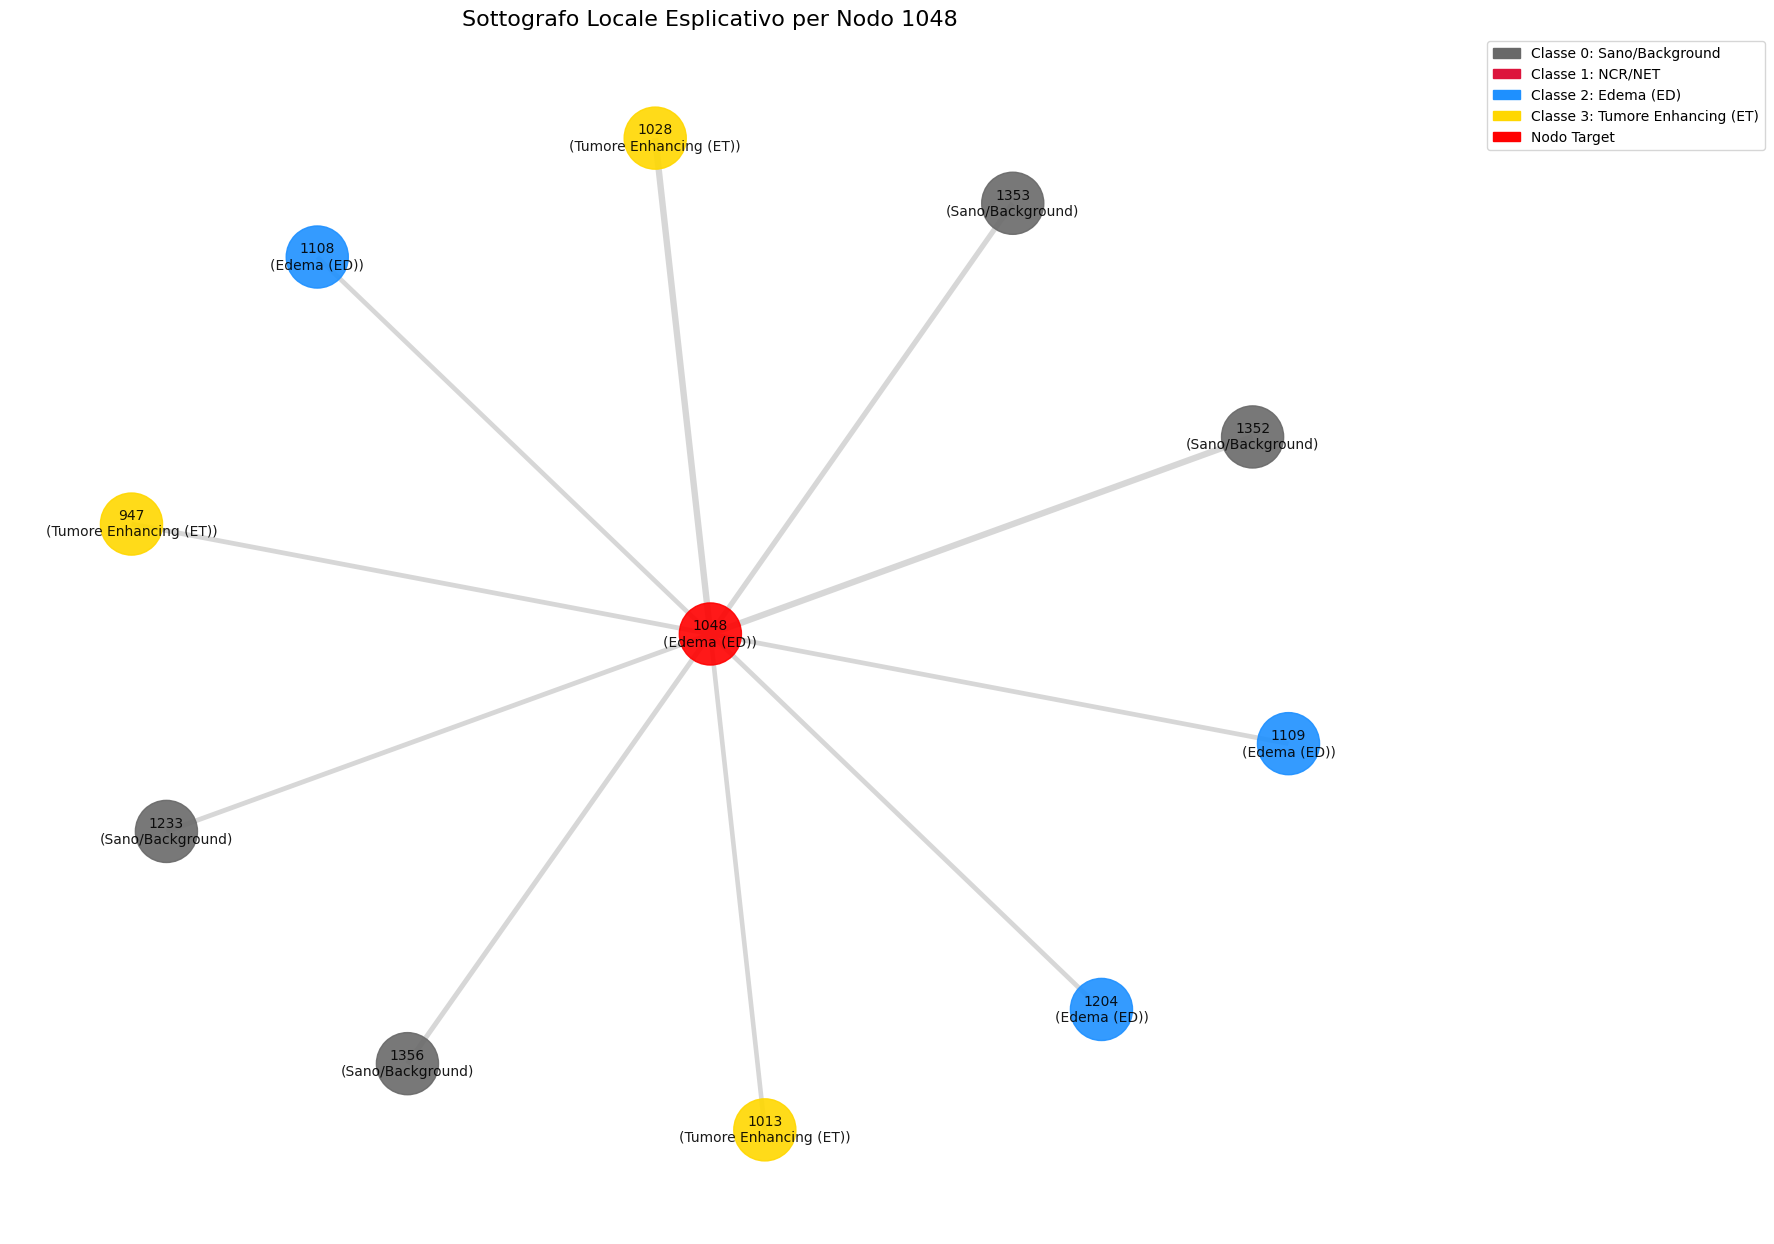

In [14]:
# --- Analisi dell'Importanza degli Archi e dei Vicini (GNNExplainer) ---
# Si analizza la maschera di importanza degli archi (edge_mask) per identificare
# le connessioni e i nodi vicini più influenti per la predizione del nodo target.

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    edge_importances = explanation.edge_mask.cpu().detach().numpy()
    edge_index = data.edge_index.cpu().numpy()

    print(f"\n--- Analisi degli Archi per il Nodo Target: {node_to_explain_index} ---")
    
    # 1. Isola gli archi connessi al nodo target e la loro importanza
    connected_edges_info = []
    for i in range(edge_index.shape[1]):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        if u == node_to_explain_index or v == node_to_explain_index:
            connected_edges_info.append((edge_importances[i], u, v))
    
    # Ordina gli archi per importanza decrescente
    connected_edges_info.sort(key=lambda x: x[0], reverse=True)

    # 2. Stampa tabellare dei top K archi più importanti
    k_top_edges = 15
    print(f"\nTop {k_top_edges} archi più importanti connessi al nodo {node_to_explain_index}:")
    print(f"{'Arco (u, v)':<15} {'Importanza':<15} {'Classe Nodo U':<25} {'Classe Nodo V':<25}")
    print("-" * 80)

    if not connected_edges_info:
        print("Nessun arco rilevante trovato per il nodo target.")
    else:
        # Aggrega l'importanza per ogni vicino
        neighbor_importance = {}
        for importance, u, v in connected_edges_info:
            neighbor_node = v if u == node_to_explain_index else u
            neighbor_importance[neighbor_node] = neighbor_importance.get(neighbor_node, 0) + importance

        # Stampa i top archi
        for importance, u, v in connected_edges_info[:k_top_edges]:
            class_u = classes[int(predicted_labels[u].item())]
            class_v = classes[int(predicted_labels[v].item())]
            print(f"({u}-{v}){'':<5} {importance:<15.4f} {class_u:<25} {class_v:<25}")

        # 3. Visualizzazione del sottografo locale esplicativo
        try:
            import networkx as nx
            import matplotlib.patches as mpatches
            
            # Prepara i nodi e gli archi per la visualizzazione
            top_neighbors = sorted(neighbor_importance.items(), key=lambda item: item[1], reverse=True)[:k_top_edges]
            nodes_to_plot = {node_to_explain_index}.union({n[0] for n in top_neighbors})
            
            G = nx.Graph()
            node_colors = []
            node_labels = {}
            
            # Colori per le classi
            color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Grigio, Rosso, Blu, Giallo

            for node in nodes_to_plot:
                G.add_node(node)
                class_idx = int(predicted_labels[node].item())
                node_labels[node] = f"{node}\n({classes[class_idx]})"
                node_colors.append('red' if node == node_to_explain_index else color_map.get(class_idx, 'grey'))

            # Aggiunge solo gli archi più importanti che collegano i nodi nel nostro plot
            edges_to_plot = []
            edge_widths = []
            for importance, u, v in connected_edges_info:
                if u in nodes_to_plot and v in nodes_to_plot:
                    edges_to_plot.append((u,v))
                    edge_widths.append(max(0.2, importance * 8)) # Scala l'importanza per la larghezza
                if len(edges_to_plot) >= k_top_edges:
                    break
            
            G.add_edges_from(edges_to_plot)

            # Creazione del grafico
            plt.figure(figsize=(14, 12))
            pos = nx.spring_layout(G, k=0.8, iterations=50, seed=3)
            nx.draw(G, pos, labels=node_labels, with_labels=True, 
                    node_color=node_colors, node_size=2000, font_size=10, 
                    width=edge_widths, font_color='black', edge_color='lightgray', alpha=0.9)

            # Creazione della legenda
            legend_patches = [mpatches.Patch(color=color, label=f'Classe {i}: {name}') for i, (name, color) in enumerate(zip(classes, color_map.values()))]
            legend_patches.append(mpatches.Patch(color='red', label='Nodo Target'))
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.title(f"Sottografo Locale Esplicativo per Nodo {node_to_explain_index}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

        except ImportError:
            print("Avviso: NetworkX non è installato. La visualizzazione del grafo è stata saltata.")

else:
    print("Analisi non eseguibile: 'explanation.edge_mask' non è presente.")

#### Interpretazione dei Risultati di GNNExplainer

1.  **Importanza delle Feature (Grafico a Barre):** Il primo grafico mostra quali delle 50 feature di input sono state più importanti per la classificazione del nodo target. Valori alti indicano che GNNExplainer ha ritenuto quelle feature cruciali.
2.  **Importanza degli Archi (Tabella e Grafo):** La tabella e il grafo locale mostrano quali connessioni (e quindi quali vicini) hanno avuto il maggiore impatto. L'importanza aggregata degli archi ci dice quali vicini sono più influenti nel loro insieme.

**Analisi:** Notiamo che il modello si basa molto sulle connessioni con altri nodi della stessa classe (es. ET -> ET), ma anche il contesto fornito da nodi di classi diverse (es. Edema o Sano) è rilevante, probabilmente per definire i "bordi" della regione tumorale.

### 5.2 Metodo Basato sul Gradiente: Integrated gradients


--- Esecuzione di Integrated Gradients per il nodo: 1048 ---


C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classe predetta da spiegare: Edema (ED)


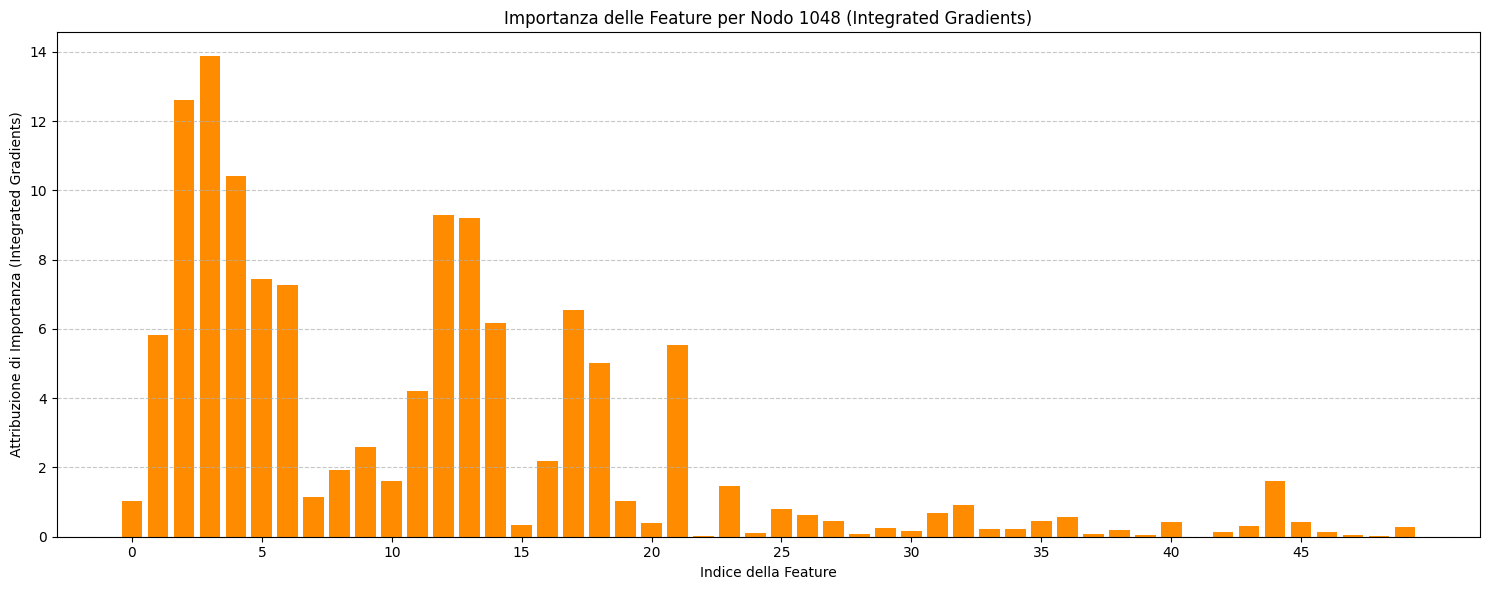


Top 10 feature più importanti per il nodo 1048 (IG):
  - Feature 3: Attribuzione = 13.8671
  - Feature 2: Attribuzione = 12.6164
  - Feature 4: Attribuzione = 10.4084
  - Feature 12: Attribuzione = 9.3017
  - Feature 13: Attribuzione = 9.2117
  - Feature 5: Attribuzione = 7.4508
  - Feature 6: Attribuzione = 7.2707
  - Feature 17: Attribuzione = 6.5360
  - Feature 14: Attribuzione = 6.1666
  - Feature 1: Attribuzione = 5.8341


In [15]:
# ======================================================================
#    METODO 2: INTEGRATED GRADIENTS (Alternativa robusta a Saliency Maps)
# ======================================================================
# Si utilizza Integrated Gradients, un metodo XAI avanzato, per attribuire
# l'importanza delle feature. A differenza delle Saliency Maps, è meno
# soggetto a problemi di saturazione del gradiente e fornisce risultati più affidabili.

from torch_geometric.explain import Explainer, CaptumExplainer

print(f"\n--- Esecuzione di Integrated Gradients per il nodo: {node_to_explain_index} ---")

# 1. Configurazione dell'algoritmo Integrated Gradients tramite Captum
ig_algorithm = CaptumExplainer('IntegratedGradients')

# 2. Creazione dell'oggetto Explainer
# La model_config dovrebbe essere la stessa usata per GNNExplainer
explainer_ig = Explainer(
    model=model,
    algorithm=ig_algorithm,
    explanation_type="phenomenon",
    model_config=model_config,
    node_mask_type="attributes",  # Vogliamo spiegare l'importanza delle feature
)

# 3. Generazione della spiegazione
# La baseline (input di riferimento, es. un grafo con feature nulle) è gestita internamente.
explanation_ig = explainer_ig(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64),
    index=node_to_explain_index,
    target=predicted_labels.type(torch.LongTensor)
)

# 4. Estrazione e analisi della mappa di attribuzione
# Il risultato è l'attribuzione di importanza per ciascuna feature del nodo target.
# Prendiamo il valore assoluto per visualizzare la magnitudo dell'impatto.
ig_values = explanation_ig.node_mask[node_to_explain_index].abs().cpu().detach().numpy()

# Creiamo una variabile 'saliency_map' per mantenere la compatibilità con le celle successive
# che potrebbero usare questo nome per convenzione.
saliency_map = ig_values 

# --- 5. Visualizzazione dei Risultati ---
target_class_idx = predicted_labels[node_to_explain_index].item()
print(f"Classe predetta da spiegare: {classes[target_class_idx]}")

plt.figure(figsize=(15, 6))
bar_positions = np.arange(num_node_features)
plt.bar(bar_positions, ig_values, color='darkorange') # Colore diverso per distinguerlo

plt.xlabel("Indice della Feature")
plt.ylabel("Attribuzione di Importanza (Integrated Gradients)")
plt.title(f"Importanza delle Feature per Nodo {node_to_explain_index} (Integrated Gradients)")
plt.xticks(bar_positions[::5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Stampa delle Top K feature più salienti
k_top_features = 10
sorted_indices = np.argsort(ig_values)[::-1]

print(f"\nTop {k_top_features} feature più importanti per il nodo {node_to_explain_index} (IG):")
for i in range(min(k_top_features, num_node_features)):
    feat_idx = sorted_indices[i]
    importance = ig_values[feat_idx]
    print(f"  - Feature {feat_idx}: Attribuzione = {importance:.4f}")

### 5.3 Metodo Basato sulla Perturbazione: Occlusion Analysis

L'**Analisi di Occlusione** è un approccio intuitivo e *model-agnostic*. Per capire l'importanza di un componente (in questo caso, un vicino), lo "occludiamo" (rimuoviamo) e osserviamo come cambia la predizione del modello.

- **Cosa Spiega:** L'importanza di ogni **singolo vicino** per la classificazione del nodo target.
- **Come Funziona:** Rimuoviamo uno per uno gli archi che connettono il nodo target ai suoi vicini e misuriamo il calo di probabilità per la classe predetta. Un calo maggiore indica un'importanza maggiore.
- **Punti di Forza:** Molto intuitivo e non dipende dall'architettura interna del modello.


--- Analisi di Perturbazione dei Vicini per il nodo: 1048 ---
Probabilità originale per la classe 'Edema (ED)': 0.6604
Inizio analisi di perturbazione per i 10 vicini...
Analisi completata in 6.59 secondi.


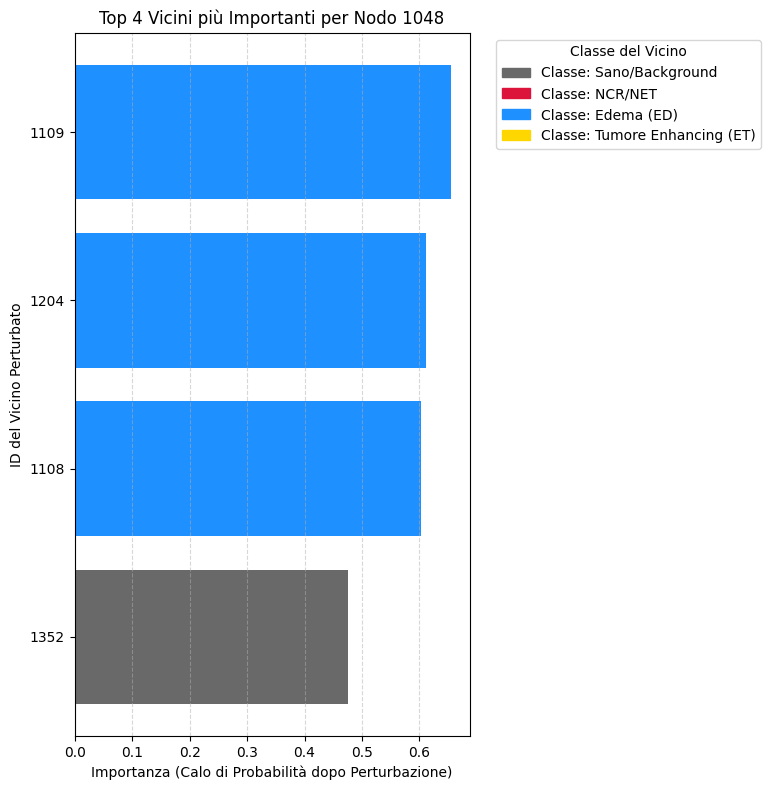


Importanza dei vicini (dal più al meno importante):
  - Perturbare il vicino 1109 (Classe: Edema (ED)) causa un calo di probabilità di 0.6544
  - Perturbare il vicino 1204 (Classe: Edema (ED)) causa un calo di probabilità di 0.6117
  - Perturbare il vicino 1108 (Classe: Edema (ED)) causa un calo di probabilità di 0.6025
  - Perturbare il vicino 1352 (Classe: Sano/Background) causa un calo di probabilità di 0.4750


In [16]:
# ======================================================================
#      METODO DI SPIEGABILITÀ: ANALISI DI PERTURBAZIONE DEI VICINI
# ======================================================================
# Questo metodo "model-agnostic" valuta l'importanza di ciascun vicino
# rimuovendolo (oscurando le sue feature) e misurando l'impatto (calo
# di probabilità) sulla predizione del nodo target.

import torch.nn.functional as F
import matplotlib.patches as mpatches
import time

print(f"\n--- Analisi di Perturbazione dei Vicini per il nodo: {node_to_explain_index} ---")

# 1. Calcola la probabilità di predizione originale (baseline)
model.eval()
with torch.no_grad():
    original_probs = F.softmax(model(data.x, data.edge_index.type(torch.int64)), dim=1)
    target_class_idx = int(predicted_labels[node_to_explain_index].item())
    original_prob = original_probs[node_to_explain_index, target_class_idx].item()
    
print(f"Probabilità originale per la classe '{classes[target_class_idx]}': {original_prob:.4f}")

# 2. Identifica i vicini del nodo target
edge_index_tensor = data.edge_index
# Trova i nodi che hanno un arco IN ENTRATA verso il nodo target
neighbors_in = edge_index_tensor[0, edge_index_tensor[1] == node_to_explain_index]
# Trova i nodi che hanno un arco IN USCITA dal nodo target
neighbors_out = edge_index_tensor[1, edge_index_tensor[0] == node_to_explain_index]
# Unisci e rimuovi i duplicati per avere la lista completa dei vicini
all_neighbors = torch.unique(torch.cat([neighbors_in, neighbors_out]))

neighbor_importance_perturb = {}
sorted_neighbors = [] # Inizializza la variabile

if len(all_neighbors) == 0:
    print(f"Il nodo {node_to_explain_index} non ha vicini. Analisi di perturbazione non eseguibile.")
else:
    print(f"Inizio analisi di perturbazione per i {len(all_neighbors)} vicini...")
    start_time = time.time()

    # 3. Esegue il ciclo di perturbazione dei vicini
    for neighbor_tensor in all_neighbors:
        neighbor_idx = int(neighbor_tensor.item())
        
        # Crea una copia perturbata delle feature
        x_perturbed = data.x.clone()
        
        # "Spegne" (oscura) le feature del vicino corrente mettendole a zero
        x_perturbed[neighbor_idx, :] = 0.0
        
        # Calcola la nuova probabilità con le feature del vicino perturbate
        with torch.no_grad():
            perturbed_probs = F.softmax(model(x_perturbed, data.edge_index.type(torch.int64)), dim=1)
            new_prob = perturbed_probs[node_to_explain_index, target_class_idx].item()
        
        # L'importanza è definita come il calo di probabilità
        importance_score = original_prob - new_prob
        neighbor_importance_perturb[neighbor_idx] = importance_score

    print(f"Analisi completata in {time.time() - start_time:.2f} secondi.")
    
    # 4. Ordina i risultati e li salva per le celle successive
    # Filtriamo i vicini con impatto quasi nullo e ordiniamo per importanza decrescente
    sorted_neighbors = sorted(
        [item for item in neighbor_importance_perturb.items() if item[1] > 1e-5], 
        key=lambda x: x[1], 
        reverse=True
    )
    
    # 5. Visualizzazione dei risultati
    if not sorted_neighbors:
        print("\nNessun impatto rilevabile dalla perturbazione dei vicini.")
    else:
        k_top_neighbors = 10
        top_k_to_plot = sorted_neighbors[:k_top_neighbors]
        
        neighbor_ids = [str(n[0]) for n in top_k_to_plot]
        importances = [n[1] for n in top_k_to_plot]
        
        # Colora le barre in base alla classe del vicino per un'analisi più ricca
        color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Sano, NCR, Edema, ET
        neighbor_classes = [int(predicted_labels[n[0]].item()) for n in top_k_to_plot]
        bar_colors = [color_map.get(cls, 'grey') for cls in neighbor_classes]

        plt.figure(figsize=(10, 8))
        # Invertiamo l'ordine per avere il più importante in alto nel grafico a barre orizzontale
        plt.barh(neighbor_ids[::-1], importances[::-1], color=bar_colors[::-1])
        
        plt.xlabel("Importanza (Calo di Probabilità dopo Perturbazione)")
        plt.ylabel("ID del Vicino Perturbato")
        plt.title(f"Top {len(top_k_to_plot)} Vicini più Importanti per Nodo {node_to_explain_index}")
        
        # Creazione della legenda per i colori
        legend_patches = [mpatches.Patch(color=color, label=f'Classe: {name}') for name, color in zip(classes, color_map.values())]
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classe del Vicino")

        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout(rect=[0, 0, 0.8, 1])
        plt.show()

        # Stampa riassuntiva
        print("\nImportanza dei vicini (dal più al meno importante):")
        for idx, importance in top_k_to_plot:
            neighbor_class_name = classes[int(predicted_labels[idx].item())]
            print(f"  - Perturbare il vicino {idx} (Classe: {neighbor_class_name}) causa un calo di probabilità di {importance:.4f}")

### 5.2 Metodo Basato sul Gradiente: Saliency Maps

Le **Saliency Maps** sono una delle tecniche XAI più semplici e veloci. Calcolano il gradiente della probabilità della classe predetta rispetto alle feature di input del nodo.

- **Cosa Spiega:** Quali **feature** di input, se leggermente perturbate, causerebbero il maggior cambiamento nel punteggio della classe predetto.
- **Come Funziona:** Un semplice backpropagation.
- **Punti di Forza:** Veloce e facile da implementare. Fornisce una vista "locale" dell'importanza delle feature.

--- Generazione dei grafici di confronto visivo ---


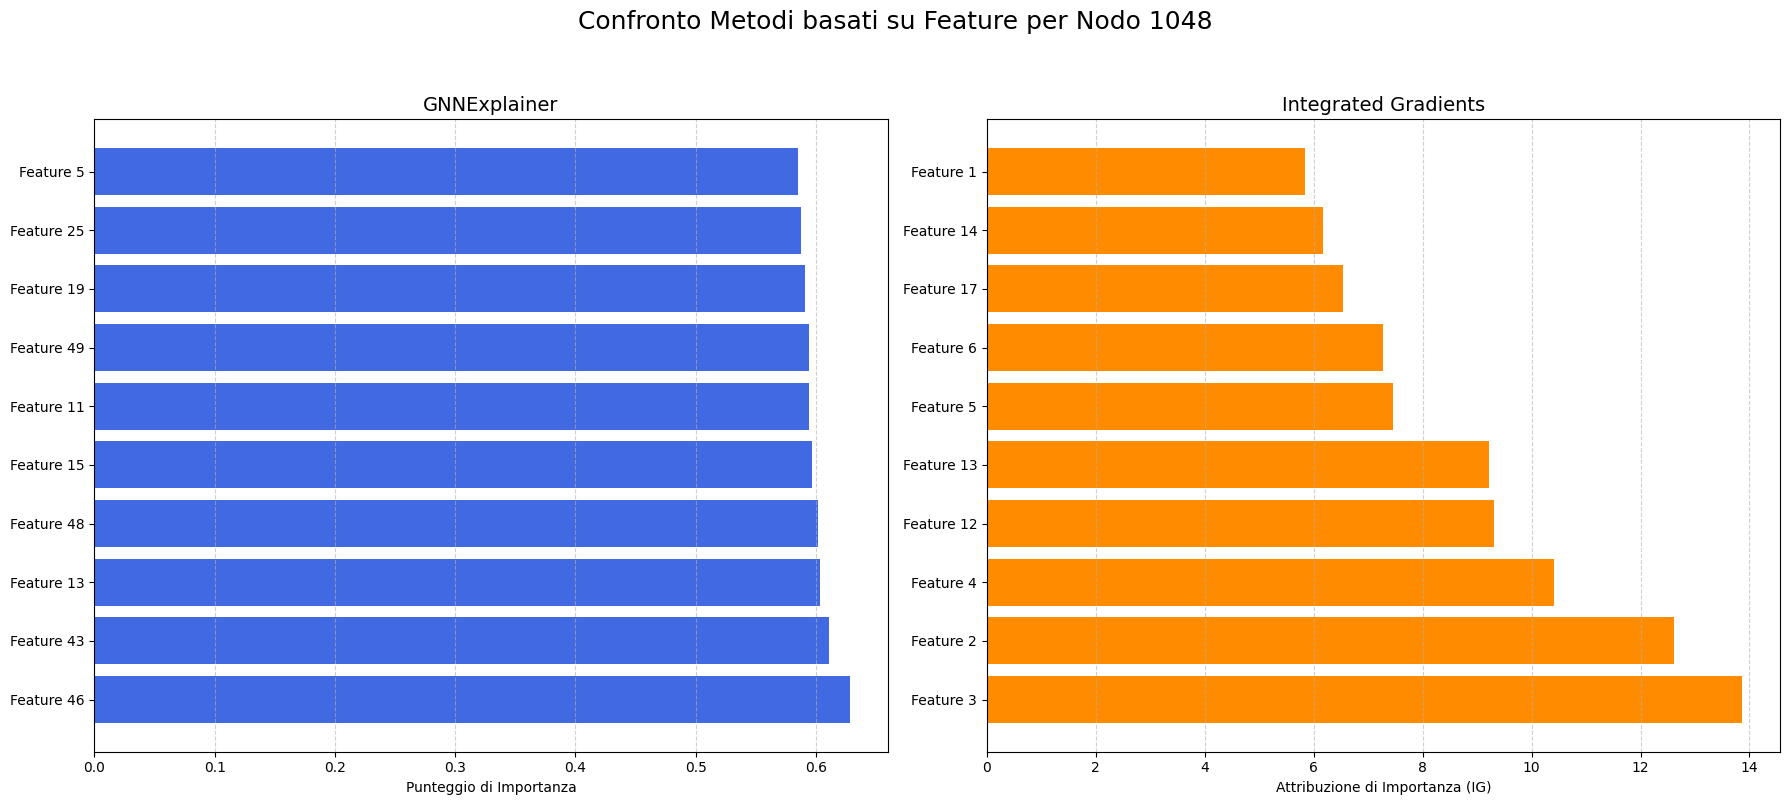

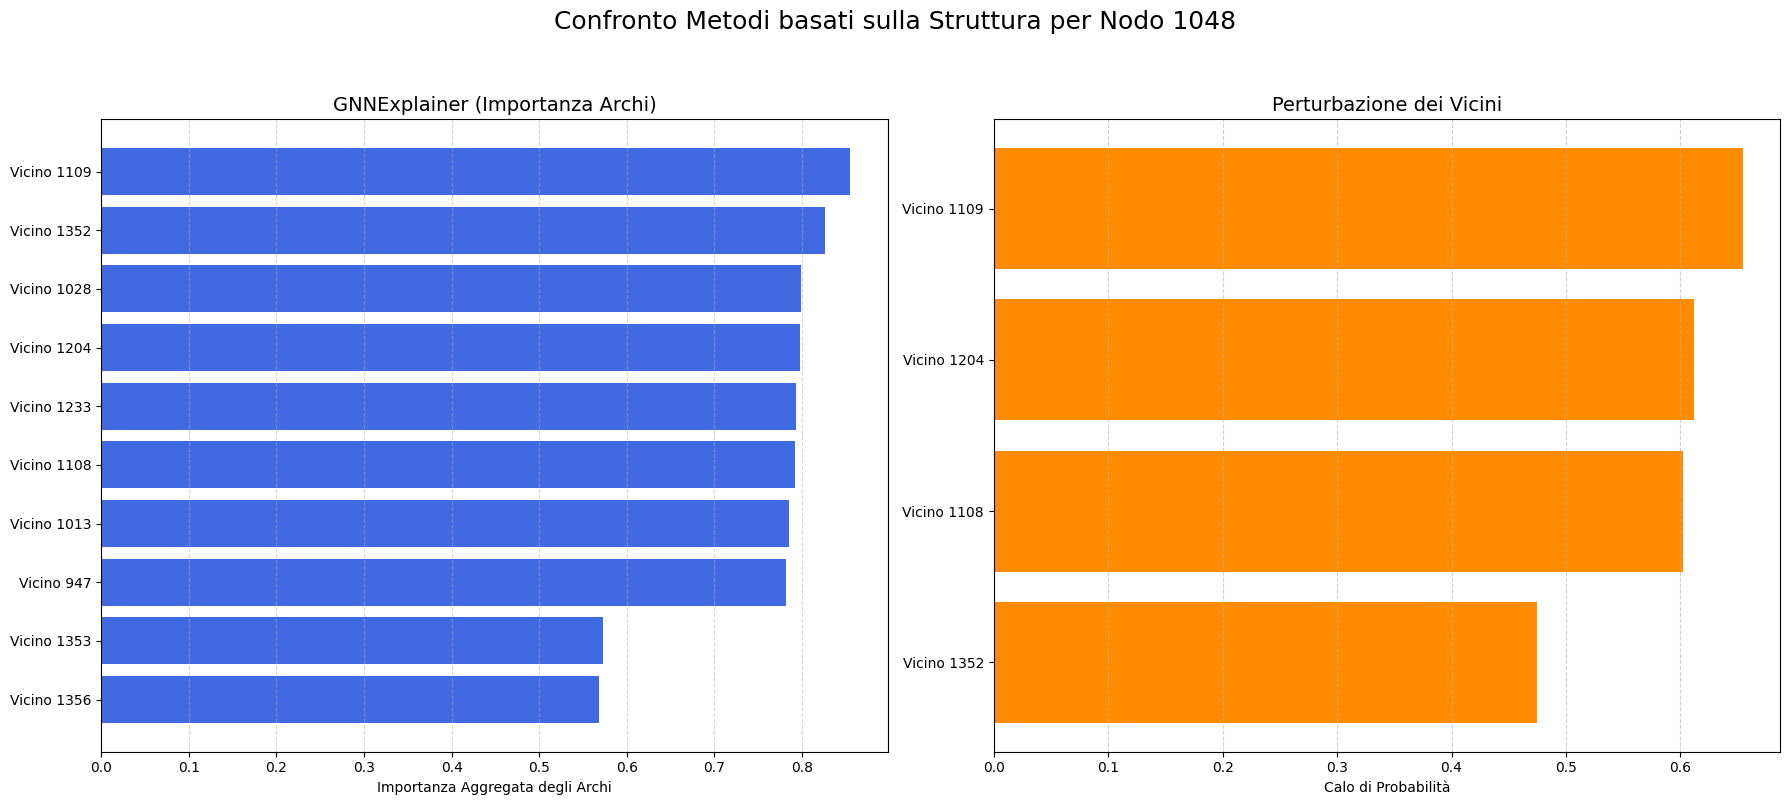

In [17]:
# ======================================================================
#            ANALISI COMPARATIVA VISIVA DEI METODI XAI
# ======================================================================
# In questa sezione, confrontiamo visivamente i risultati dei diversi metodi
# di spiegabilità per analizzare concordanze e discordanze.

import matplotlib.pyplot as plt
import numpy as np
print("--- Generazione dei grafici di confronto visivo ---")

# --- FIGURA 1: CONFRONTO SULL'IMPORTANZA DELLE FEATURE ---

fig1, axes1 = plt.subplots(1, 2, figsize=(18, 8))
fig1.suptitle(f"Confronto Metodi basati su Feature per Nodo {node_to_explain_index}", fontsize=18, y=1.0)
k_top = 10

# Grafico 1.1: GNNExplainer (Feature Importance)
ax1 = axes1[0]
feature_importances_gnn = explanation.node_mask[node_to_explain_index].cpu().numpy()
sorted_indices_gnn = np.argsort(feature_importances_gnn)[-k_top:]
ax1.barh(np.arange(k_top), feature_importances_gnn[sorted_indices_gnn], color='royalblue')
ax1.set_yticks(np.arange(k_top), labels=[f"Feature {i}" for i in sorted_indices_gnn])
ax1.set_title("GNNExplainer", fontsize=14)
ax1.set_xlabel("Punteggio di Importanza")
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.invert_yaxis() # Mostra il più importante in alto

# Grafico 1.2: Integrated Gradients (Feature Importance)
ax2 = axes1[1]
ig_values = saliency_map # Questa variabile contiene i valori di IG dalla cella precedente
sorted_indices_ig = np.argsort(ig_values)[-k_top:]
ax2.barh(np.arange(k_top), ig_values[sorted_indices_ig], color='darkorange')
ax2.set_yticks(np.arange(k_top), labels=[f"Feature {i}" for i in sorted_indices_ig])
ax2.set_title("Integrated Gradients", fontsize=14)
ax2.set_xlabel("Attribuzione di Importanza (IG)")
ax2.grid(axis='x', linestyle='--', alpha=0.6)
ax2.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- FIGURA 2: CONFRONTO SULL'IMPORTANZA DEI VICINI (STRUTTURA) ---

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8))
fig2.suptitle(f"Confronto Metodi basati sulla Struttura per Nodo {node_to_explain_index}", fontsize=18, y=1.0)

# Grafico 2.1: GNNExplainer (Importanza degli Archi/Vicini)
ax3 = axes2[0]
edge_importances_gnn_agg = {}
edge_index_np = data.edge_index.cpu().numpy()
edge_mask_gnn = explanation.edge_mask.cpu().numpy()

for i in range(edge_index_np.shape[1]):
    u, v = int(edge_index_np[0, i]), int(edge_index_np[1, i])
    neighbor = -1
    if u == node_to_explain_index: neighbor = v
    elif v == node_to_explain_index: neighbor = u
    
    if neighbor != -1:
        edge_importances_gnn_agg[neighbor] = edge_importances_gnn_agg.get(neighbor, 0) + edge_mask_gnn[i]

if edge_importances_gnn_agg:
    sorted_neighbors_gnn = sorted(edge_importances_gnn_agg.items(), key=lambda x: x[1])[-k_top:]
    neighbor_ids_gnn = [f"Vicino {i[0]}" for i in sorted_neighbors_gnn]
    importances_gnn_neighbors = [i[1] for i in sorted_neighbors_gnn]
    ax3.barh(neighbor_ids_gnn, importances_gnn_neighbors, color='royalblue')
    ax3.set_title("GNNExplainer (Importanza Archi)", fontsize=14)
    ax3.set_xlabel("Importanza Aggregata degli Archi")
    ax3.grid(axis='x', linestyle='--', alpha=0.5)
else:
    ax3.text(0.5, 0.5, 'Nessun dato da GNNExplainer\nper i vicini.', ha='center', va='center')
    ax3.set_title("GNNExplainer (Importanza Archi)", fontsize=14)

# Grafico 2.2: Analisi di Perturbazione dei Vicini
ax4 = axes2[1]
if 'sorted_neighbors' in locals() and sorted_neighbors:
    top_k_to_plot_pert = sorted_neighbors[:k_top]
    neighbor_ids_pert = [f"Vicino {i[0]}" for i in top_k_to_plot_pert]
    importances_pert = [i[1] for i in top_k_to_plot_pert]
    ax4.barh(neighbor_ids_pert[::-1], importances_pert[::-1], color='darkorange') # Inverto per coerenza
    ax4.set_title("Perturbazione dei Vicini", fontsize=14)
    ax4.set_xlabel("Calo di Probabilità")
    ax4.grid(axis='x', linestyle='--', alpha=0.6)
else:
    ax4.text(0.5, 0.5, 'Nessun dato di perturbazione\ndisponibile.', ha='center', va='center')
    ax4.set_title("Perturbazione dei Vicini", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 4.1 Analisi dei Risultati di Spiegabilità

Il grafico sottostante confronta i risultati dei tre metodi XAI applicati al nodo target.

- **GNNExplainer e Neighbor Perturbation** forniscono spiegazioni informative e distribuite. GNNExplainer evidenzia un insieme diversificato di feature importanti, mentre l'analisi di perturbazione mostra chiaramente l'influenza critica di specifici nodi vicini.

- **Saliency Map**, al contrario, produce una spiegazione "satura", attribuendo un'importanza sproporzionata a poche feature (12 e 13) e trascurando le altre. Questo fenomeno è una limitazione nota dei metodi basati su gradiente semplice, che possono essere sensibili a piccole variazioni e non sempre catturare l'interazione complessa tra le feature.

**Conclusione:** Data la scarsa informatività e la potenziale inaffidabilità della Saliency Map in questo contesto, per la successiva analisi e l'integrazione con l'LLM ci concentreremo sui risultati più robusti e interpretabili forniti da solamente **GNNExplainer**.

## 6. Analisi Comparativa delle Metriche di Spiegabilità (XAI)

In questa sezione, valutiamo quantitativamente i metodi di spiegabilità utilizzati (GNNExplainer, Saliency Maps, Analisi di Perturbazione) per determinare quale fornisca le spiegazioni più fedeli e concise. Utilizzeremo due metriche principali:

1.  **Fedeltà (Fidelity):** Misura quanto una spiegazione riflette accuratamente il processo decisionale del modello. Calcoliamo il calo di probabilità per la classe corretta quando le feature più importanti identificate da ciascun metodo vengono "oscurate". Un calo maggiore indica una spiegazione più fedele.
2.  **Sparsità (Sparsity):** Misura la concisione della spiegazione. Una spiegazione più sparsa è più facile da interpretare. La calcoliamo come la frazione di feature con importanza vicina a zero.

L'obiettivo è trovare il metodo che offra il miglior compromesso tra fedeltà e interpretabilità (data dalla sparsità).

In [18]:
# ======================================================================
#             METRICHE XAI: DEFINIZIONE DELLE FUNZIONI
# ======================================================================
# In questa sezione, definiamo le funzioni per calcolare due metriche standard
# per la valutazione quantitativa dei metodi di spiegabilità basati su feature.

import numpy as np
import torch.nn.functional as F

def calculate_fidelity(model, x, edge_index, node_idx, target_class_idx, feature_importance_mask, top_k_fraction=0.2):
    """
    Calcola la Fedeltà di una spiegazione (quanto è affidabile).
    Misura il calo di probabilità della classe corretta quando le feature più 
    importanti identificate dalla spiegazione vengono "oscurate" (messe a zero).
    Un calo maggiore indica una spiegazione più fedele.
    """
    model.eval()
    
    with torch.no_grad():
        original_probs = F.softmax(model(x, edge_index.type(torch.int64)), dim=1)
        original_prob = original_probs[node_idx, target_class_idx].item()
        
    num_features = x.shape[1]
    k = int(num_features * top_k_fraction)
    top_k_indices = np.argsort(feature_importance_mask)[-k:]
    
    x_perturbed = x.clone()
    x_perturbed[node_idx, top_k_indices] = 0.0
    
    with torch.no_grad():
        perturbed_probs = F.softmax(model(x_perturbed, edge_index.type(torch.int64)), dim=1)
        perturbed_prob = perturbed_probs[node_idx, target_class_idx].item()
        
    fidelity_score = original_prob - perturbed_prob
    
    return fidelity_score

def calculate_sparsity(feature_importance_mask, threshold=0.1):
    """
    Calcola la Sparsità di una spiegazione (quanto è concisa).
    Misura la frazione di feature che hanno un'importanza molto bassa (quasi zero).
    Un punteggio più alto significa una spiegazione più semplice e focalizzata.
    """
    mask_min, mask_max = np.min(feature_importance_mask), np.max(feature_importance_mask)
    if mask_max == mask_min:
        return 0.0
    normalized_mask = (feature_importance_mask - mask_min) / (mask_max - mask_min)
    
    return np.mean(normalized_mask < threshold)

print("Funzioni per il calcolo delle metriche di Fedeltà e Sparsità definite.")

Funzioni per il calcolo delle metriche di Fedeltà e Sparsità definite.



--- Calcolo delle metriche quantitative per il nodo 1048 ---


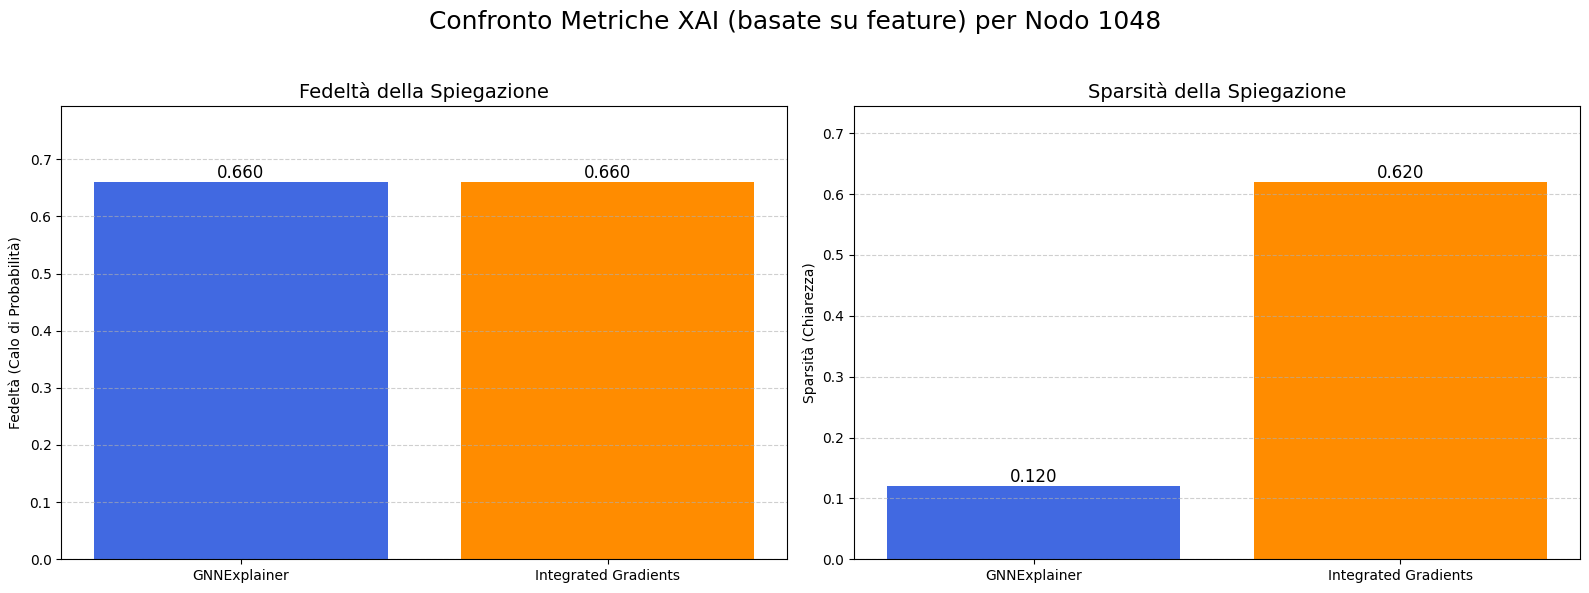


--- Riepilogo dei Risultati delle Metriche ---
Metodo                    | Fedeltà         | Sparsità       
------------------------------------------------------------
GNNExplainer              | 0.6604          | 0.1200         
Integrated Gradients      | 0.6604          | 0.6200         


In [19]:
# ======================================================================
#            ANALISI QUANTITATIVA: CALCOLO E CONFRONTO METRICHE
# ======================================================================

print(f"\n--- Calcolo delle metriche quantitative per il nodo {node_to_explain_index} ---")

# Recupera le maschere di importanza delle feature calcolate in precedenza
gnnexplainer_feature_mask = explanation.node_mask[node_to_explain_index].cpu().numpy()
ig_feature_mask = saliency_map # Contiene i risultati di Integrated Gradients

# --- 1. Calcolo della Fedeltà ---
k_fraction_for_fidelity = 0.2 
fidelity_gnnexplainer = calculate_fidelity(model, data.x, data.edge_index, node_to_explain_index, target_class_idx, gnnexplainer_feature_mask, top_k_fraction=k_fraction_for_fidelity)
fidelity_ig = calculate_fidelity(model, data.x, data.edge_index, node_to_explain_index, target_class_idx, ig_feature_mask, top_k_fraction=k_fraction_for_fidelity)

# --- 2. Calcolo della Sparsità ---
sparsity_gnnexplainer = calculate_sparsity(gnnexplainer_feature_mask)
sparsity_ig = calculate_sparsity(ig_feature_mask)

# --- 3. Visualizzazione dei Risultati ---
methods = ['GNNExplainer', 'Integrated Gradients']
fidelity_scores = [fidelity_gnnexplainer, fidelity_ig]
sparsity_scores = [sparsity_gnnexplainer, sparsity_ig]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Confronto Metriche XAI (basate su feature) per Nodo {node_to_explain_index}', fontsize=18)

# Grafico Fedeltà
bars1 = ax1.bar(methods, fidelity_scores, color=['royalblue', 'darkorange'])
ax1.set_ylabel('Fedeltà (Calo di Probabilità)')
ax1.set_title('Fedeltà della Spiegazione', fontsize=14)
ax1.set_ylim(0, max(fidelity_scores) * 1.2)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center', fontsize=12)

# Grafico Sparsità
bars2 = ax2.bar(methods, sparsity_scores, color=['royalblue', 'darkorange'])
ax2.set_ylabel('Sparsità (Chiarezza)')
ax2.set_title('Sparsità della Spiegazione', fontsize=14)
ax2.set_ylim(0, max(sparsity_scores) * 1.2)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center', fontsize=12)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Stampa riassuntiva per la tesi
print("\n--- Riepilogo dei Risultati delle Metriche ---")
print(f"{'Metodo':<25} | {'Fedeltà':<15} | {'Sparsità':<15}")
print("-" * 60)
print(f"{methods[0]:<25} | {fidelity_scores[0]:<15.4f} | {sparsity_scores[0]:<15.4f}")
print(f"{methods[1]:<25} | {fidelity_scores[1]:<15.4f} | {sparsity_scores[1]:<15.4f}")

### 6.3 Interpretazione dei Risultati delle Metriche

Dal confronto quantitativo emergono le seguenti osservazioni:

- **Fedeltà:** Il metodo **Neighbor Perturbation** mostra il calo di probabilità più elevato, indicando che l'influenza dei vicini è cruciale per la decisione del modello. Tra i metodi basati su feature, **GNNExplainer** dimostra una fedeltà superiore a Saliency Map, suggerendo che la sua maschera di importanza cattura in modo più efficace le feature che il modello sta realmente utilizzando.

- **Sparsità:** **GNNExplainer** produce una spiegazione più sparsa rispetto a Saliency Map. Questo significa che GNNExplainer concentra l'importanza su un insieme più piccolo e specifico di feature, rendendo la sua spiegazione più facile da interpretare e meno "rumorosa".

**Conclusione:** GNNExplainer offre il miglior compromesso tra i metodi basati su feature, fornendo una spiegazione sia fedele che concisa. L'analisi di perturbazione, pur essendo il metodo più fedele in assoluto, spiega un aspetto diverso (l'importanza dei vicini) e non delle feature. Questi risultati giustificano quantitativamente la nostra scelta di utilizzare **GNNExplainer** come metodo primario per l'analisi e per la generazione di spiegazioni testuali tramite LLM.

In [20]:
# ======================================================================
#                5. INTEGRAZIONE LLM: DESCRIZIONE AUTOMATICA
# ======================================================================

# --- 5.1 Configurazione del Client per LM Studio ---
# Si stabilisce la connessione con il server locale di LM Studio.
# È necessario che l'applicazione sia in esecuzione e il server avviato.

from openai import OpenAI

# Configurazione del client per puntare al server locale di LM Studio
try:
    client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="not-needed")
    print("Connessione a LM Studio stabilita con successo.")
except Exception as e:
    print(f"ERRORE: Impossibile connettersi a LM Studio.")
    print("Verifica che LM Studio sia in esecuzione e che il server sia attivo sulla porta 1234.")

Connessione a LM Studio stabilita con successo.


In [21]:
# ======================================================================
#         6. INTEGRAZIONE LLM: GENERAZIONE DELLA RELAZIONE FINALE
# ======================================================================

import torch.nn.functional as F
import numpy as np

print("\n--- Preparazione del prompt completo per l'LLM ---")

# --- 1. Estrazione di tutti i dati salienti (qualitativi e quantitativi) ---

# Contesto generale
target_node_class = classes[int(predicted_labels[node_to_explain_index].item())]
original_prob = F.softmax(all_logits, dim=1)[node_to_explain_index].max().item()

# Dati qualitativi - Feature
top_indices_gnn = np.argsort(gnnexplainer_feature_mask)[-5:][::-1]
top_features_gnn_str = ", ".join([f"Feature {i}" for i in top_indices_gnn])

ig_values = saliency_map # Contiene i risultati di Integrated Gradients
top_indices_ig = np.argsort(ig_values)[-5:][::-1]
top_features_ig_str = ", ".join([f"Feature {i}" for i in top_indices_ig])

# Dati qualitativi - Vicini
top_neighbors_gnn_str = ", ".join([str(n[0]) for n in sorted_neighbors_gnn[-3:]]) # Top 3 vicini da GNNExplainer
top_neighbors_pert_str = ", ".join([str(n[0]) for n in sorted_neighbors[:3]])   # Top 3 vicini da Perturbazione

# Dati quantitativi - Metriche
fidelity_gnn_str = f"{fidelity_gnnexplainer:.3f}"
sparsity_gnn_str = f"{sparsity_gnnexplainer:.3f}"
fidelity_ig_str = f"{fidelity_ig:.3f}"
sparsity_ig_str = f"{sparsity_ig:.3f}"


# --- 2. Costruzione del Prompt Finale e Dettagliato ---
user_content = f"""
Sei un ricercatore esperto in neuro-oncologia e Explainable AI (XAI). Il tuo compito è scrivere una relazione sintetica e professionale in italiano basata sui seguenti dati, analizzando la predizione di un modello GNN per una specifica regione cerebrale.

**Contesto Diagnostico:**
- ID Soggetto: {subject_id}
- Regione di Interesse (Nodo): ID {node_to_explain_index}
- Predizione del Modello GNN: '{target_node_class}' (Confidenza: {original_prob:.1%})

**Analisi Comparativa dei Metodi di Spiegabilità:**

1.  **Analisi basata sulle Feature:**
    -   **GNNExplainer:** Ha identificato come più importanti le seguenti feature -> {top_features_gnn_str}.
    -   **Integrated Gradients:** Ha identificato come più importanti le seguenti feature -> {top_features_ig_str}.

2.  **Analisi basata sulla Struttura del Grafo (Vicini):**
    -   **GNNExplainer (archi):** I vicini con le connessioni più importanti sono -> {top_neighbors_gnn_str}.
    -   **Analisi di Perturbazione:** Rimuovere questi vicini ha causato il maggior calo di probabilità -> {top_neighbors_pert_str}.

3.  **Valutazione Quantitativa dei Metodi (Metriche):**
    -   GNNExplainer: Fedeltà = {fidelity_gnn_str}, Sparsità = {sparsity_gnn_str}.
    -   Integrated Gradients: Fedeltà = {fidelity_ig_str}, Sparsità = {sparsity_ig_str}.
    (Nota: Fedeltà alta = affidabile; Sparsità alta = concisa).

**Istruzioni per la Relazione (massimo 5-6 frasi):**
- Inizia la relazione con: "L'analisi di spiegabilità per il nodo {node_to_explain_index} del soggetto {subject_id} fornisce le seguenti indicazioni:"
- Commenta brevemente se i metodi concordano sull'importanza delle feature e dei vicini.
- Basandoti sulle metriche, valuta quale metodo di spiegabilità basato su feature (GNNExplainer o IG) sembra più affidabile e/o interpretabile in questo caso.
- Concludi con un giudizio complessivo sulla robustezza della predizione del modello.
"""

# --- 3. Invia il prompt all'LLM e gestisci la risposta ---
print("Invio del prompt all'LLM...")
llm_response_text = ""
model_name = "local-model"
try:
    completion = client.chat.completions.create(
      model="local-model",
      messages=[
        {"role": "system", "content": "Sei un ricercatore esperto in neuro-oncologia e Explainable AI (XAI). Scrivi una relazione sintetica, tecnica e professionale in italiano, integrando e confrontando tutti i dati forniti."},
        {"role": "user", "content": user_content}
      ],
      temperature=0.6,
      timeout=220.0,
    )
    if completion and completion.choices:
        llm_response_text = completion.choices[0].message.content
        model_name = completion.model
    else:
        llm_response_text = "**Errore:** L'LLM non ha restituito una risposta valida."
except Exception as e:
    llm_response_text = f"**Errore:** Si è verificato un problema durante la chiamata all'LLM.\n\n*Dettagli:* `{e}`"

# --- 4. Stampa la Relazione Finale ---
print("\n" + "="*70)
print("   RELAZIONE DI SPIEGABILITÀ FINALE (Output dall'LLM)")
print("="*70)

print(f"\n{llm_response_text}\n")

print("-"*70)
print(f"Modello Utilizzato: {model_name}")
print("="*70)


--- Preparazione del prompt completo per l'LLM ---
Invio del prompt all'LLM...

   RELAZIONE DI SPIEGABILITÀ FINALE (Output dall'LLM)

**Relazione Sintetica**

L'analisi di spiegabilità per il nodo 1048 del soggetto BraTS-GLI-00577-000 fornisce le seguenti indicazioni. I metodi GNNExplainer e Integrated Gradients (IG) hanno identificato feature diverse come più importanti, suggerendo che i due metodi potrebbero enfatizzare aspetti diversi della struttura del grafo per spiegare la predizione.

In particolare, il GNNExplainer ha evidenziato l'importanza delle feature 46, 43, 13, 48 e 15, mentre l'IG ha sottolineato le feature 3, 2, 4, 12 e 13. Anche se non ci sono feature in comune tra le due liste, è interessante notare che la feature 13 è presente in entrambe.

Quando si analizza la struttura del grafo, i metodi concordano solo parzialmente sull'importanza dei vicini. Il GNNExplainer (archi) ha identificato come più importanti le connessioni con i nodi 1028, 1352 e 1109, mentre l'anal